In [86]:
from datetime import datetime, timedelta
from faker import Faker 
import pandas as pd
import csv
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import random
import openpyxl
from scipy.stats import mode
import seaborn as sns

fake = Faker()

dt_specie = pd.read_excel("/home/barry/Documents/PythonProjects/Test/specie_data.xlsx")

In [87]:
dt_specie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Species         75 non-null     object 
 1   Adult height    75 non-null     float64
 2   Child's height  75 non-null     float64
 3   Adult weight    75 non-null     float64
 4   Child's weight  75 non-null     float64
 5   Lifespan        75 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 3.6+ KB


In [88]:
def generate_date(start_date, end_date):
    return fake.date_time_between(start_date=start_date, end_date=end_date)


def create_file(file_path, header, data_generator, num_rows):
    with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
        workbook  = writer.book
        worksheet = workbook.add_worksheet()
        worksheet.write_row(0, 0, header)
        for i in range(num_rows):
            row_data = data_generator(i)
            worksheet.write_row(i + 1, 0, row_data)
            


def create_animals_row(row_id):
    if num_species[0] != 0:
        num_species[0] -= 1
    else:
        if num_species[1] == len(dt_specie) - 1:
            num_species[1] = 0
        else:
            num_species[1] += 1
            num_species[0] = numb_per_species

    entry_date_end = datetime.now()
    entry_date_start = entry_date_end - timedelta(days=int(dt_specie["Lifespan"][num_species[1]] * 365))
    entry_date = generate_date(entry_date_start, entry_date_end)
    difference = datetime.now() - entry_date
    height = 0
    weight = 0

    if (difference > timedelta(days=int(dt_specie["Lifespan"][num_species[1]] * 110))):
        maturity = True
        height = round(random.uniform(dt_specie["Child's height"][num_species[1]], dt_specie['Adult height'][num_species[1]]), 2)
        weight = round(random.uniform(dt_specie["Child's weight"][num_species[1]], dt_specie['Adult weight'][num_species[1]]), 2)
    else:
        maturity = False
        height = round(random.uniform(1.0, dt_specie["Child's height"][num_species[1]]), 2)
        weight = round(random.uniform(1.0, dt_specie["Child's weight"][num_species[1]]), 2)

    gender = random.choice(["Самец", "Самка"])
    return [fake.name().split()[0],entry_date.strftime('%Y-%m-%dT%H:%M:%S') , dt_specie['Species'][num_species[1]], maturity, weight, height, gender]



In [89]:
your_path = '/home/barry/Documents/DataTest/'
numb_per_species = 7
num_species = [numb_per_species,0]
num_rows = 490

In [90]:
animals_file_path = your_path + 'Animval.xlsx'
create_file(animals_file_path, ["Кличка", "Дата появления", "Вид","Зрелость", "Вес", "Рост", "Пол"],
            create_animals_row, num_rows)

In [91]:
dt_gd = pd.read_excel("/home/barry/Documents/DataTest/Animval.xlsx")
dt_gd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Кличка          490 non-null    object 
 1   Дата появления  490 non-null    object 
 2   Вид             490 non-null    object 
 3   Зрелость        490 non-null    bool   
 4   Вес             490 non-null    float64
 5   Рост            490 non-null    float64
 6   Пол             490 non-null    object 
dtypes: bool(1), float64(2), object(4)
memory usage: 23.6+ KB


In [92]:
dt_gd.head(3)

,Кличка,Дата появления,Вид,Зрелость,Вес,Рост,Пол
0,Tanner,2000-12-09T06:08:01,Chinese Alligator,True,41.14,208.85,Самец
1,Ariana,2021-09-22T20:48:29,Chinese Alligator,False,3.71,10.62,Самец
2,Jonathan,1988-06-30T22:14:21,Chinese Alligator,True,15.27,134.29,Самец


In [93]:
dt_gd.tail(3)

,Кличка,Дата появления,Вид,Зрелость,Вес,Рост,Пол
487,Patricia,2021-11-16T06:28:49,White-breasted hedgehog,True,0.84,27.55,Самка
488,Henry,2020-10-03T02:33:31,White-breasted hedgehog,True,0.87,10.72,Самец
489,Mary,2020-05-29T08:42:31,White-breasted hedgehog,True,0.36,23.60,Самец


In [94]:
dt_gd.describe()

,Вес,Рост
count,490.000000,490.000000
mean,5.992694,41.206918
std,17.830433,40.276316
min,0.040000,1.310000
25%,0.402500,12.252500
50%,0.880000,28.385000
75%,2.722500,60.740000
max,170.070000,256.210000


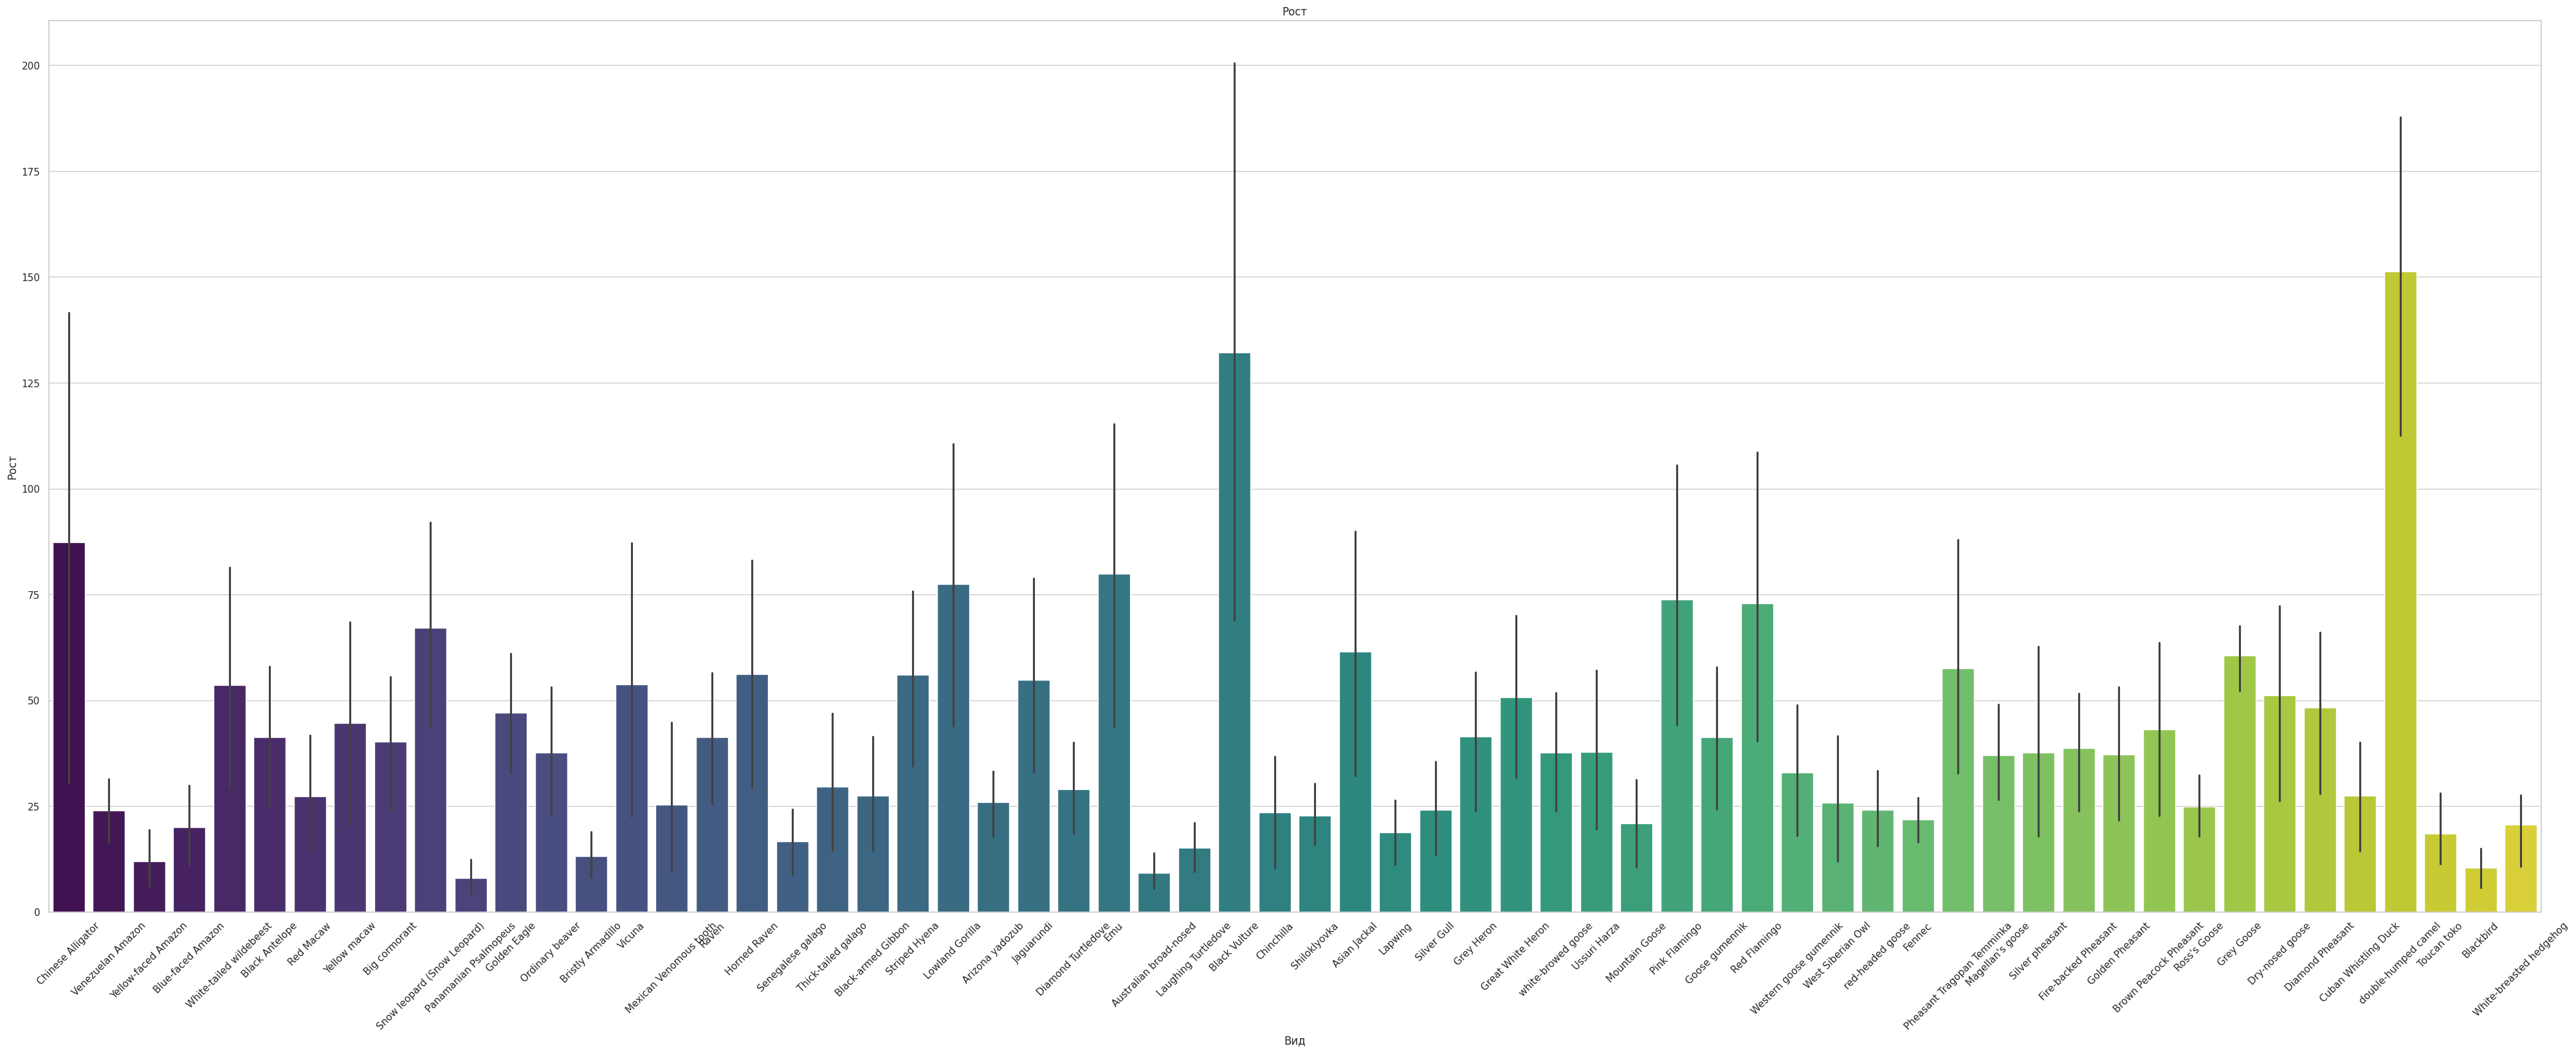

In [95]:
sns.set(style="whitegrid")

plt.figure(figsize=(50, 18))
sns.barplot(x='Вид', y='Рост', hue='Вид', data=dt_gd, palette='viridis', legend=False)

plt.xlabel('Вид')
plt.ylabel('Рост')
plt.title('Рост')

plt.xticks(rotation=45)

plt.show()


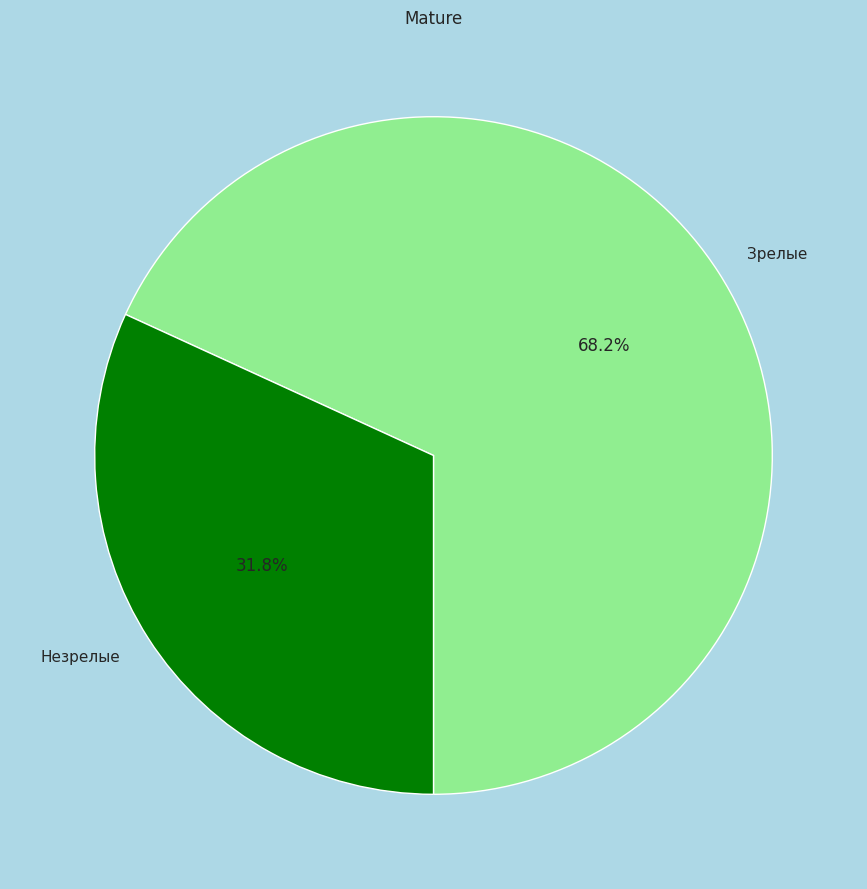

In [96]:
mature_counts = dt_gd['Зрелость'].value_counts()

label_mapping = {True: 'Зрелые', False: 'Незрелые'}
mature_counts.index = mature_counts.index.map(label_mapping)
plt.figure(figsize=(11, 11), facecolor='lightBlue')
plt.pie(mature_counts, labels=mature_counts.index, autopct='%1.01f%%', startangle=270, colors=['LightGreen', 'green'])
plt.title('Mature')
plt.show()

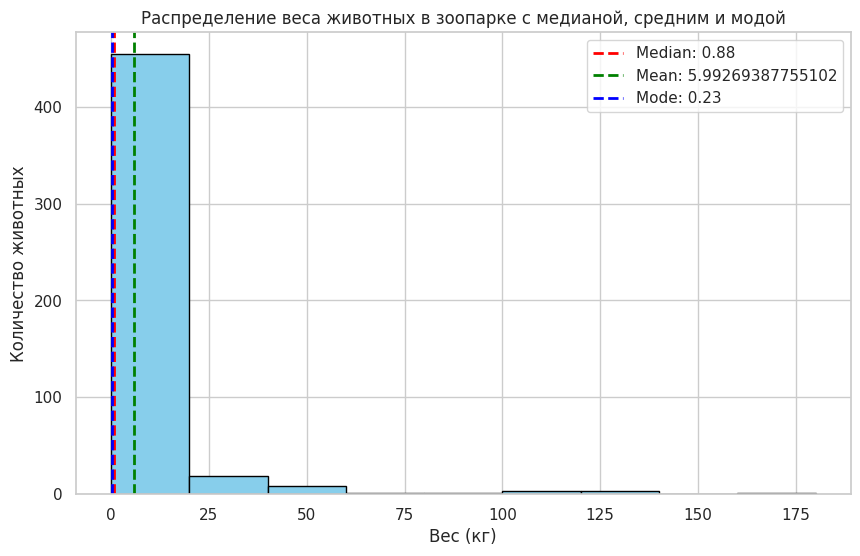

In [97]:

weights = dt_gd['Вес']


plt.figure(figsize=(10, 6))
plt.hist(weights, bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180], color='skyblue', edgecolor='black')  


median_weight = np.median(weights)
plt.axvline(median_weight, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_weight}')


mean_weight = np.mean(weights)
plt.axvline(mean_weight, color='green', linestyle='dashed', linewidth=2, label=f'Mean: {mean_weight}')


mode_result = stats.mode(weights)
mode_weight = np.atleast_1d(mode_result.mode)[0] if np.atleast_1d(mode_result.mode).size > 0 else None

if mode_weight is not None:
    plt.axvline(mode_weight, color='blue', linestyle='dashed', linewidth=2, label=f'Mode: {mode_weight}')


plt.legend()


plt.title('Распределение веса животных в зоопарке с медианой, средним и модой')
plt.xlabel('Вес (кг)')
plt.ylabel('Количество животных')
plt.show()